# General 
***
imports, functions, global parameters and preprocessing 


In [1]:
# imports
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# global parameters
CATEGORIES = 10
TEST_SIZE = 10000


In [44]:
# general functions

# create a confusion_matrix 
def create_confusion_matrix(true_labels, pred_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(true_labels, pred_labels):
        confusion_matrix[true_label, pred_label] += 1
    return confusion_matrix


# plot loss throughout time 
def plot_loss_history( title="Loss History", *args ):
    '''
    Plots the loss history over training iterations.

    Args:
        title (str): Title of the plot. Default is "Loss History".
        
        *args: Variable number of tuples, each containing the loss history data and 
               corresponding label for the plot.
               Each tuple should contain:
               - loss_history: List or array containing loss values over training iterations.
               - label: String label for the plot.

    Returns:
        None
    '''
    
    for tup in args:
        loss_history = tup[0]
        loss_label = tup[1]
        plt.plot(range(1, len(loss_history) +1), loss_history, label = loss_label, marker='o')
    
    plt.title(title)
    plt.xlabel("Training Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# plot confusion matrix
def plot_confusion_matrix(matrix, x_class_names, y_class_names, title):
    _ , axis = plt.subplots()
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]): # a confusion matrix is a square matrxi
            axis.text(j, i, format(matrix[i, j], 'd'), ha="center", va="center", color="black")
    
    plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(x_class_names))
    plt.xticks(tick_marks, x_class_names)
    plt.yticks(tick_marks, y_class_names)

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


In [40]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Assigning the features to the 'data' variable and labels to the 'labels' variable.
data, labels = mnist['data'], mnist['target']


/home/adi/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# preprocessing 
def preprocess(X, y):
    # normalize values to be between 0 and 1
    X_normalized = X / 255
    # insert column of ones as the first column of the data for bias calc down the line 
    size = X_normalized.shape[0]
    X_tilda = np.insert(X_normalized, 0, np.ones(size), axis=1)
    # convert labels to integers 
    y = y.astype(int).values
    # split the dataset to a test set and a training set 
    return train_test_split(X_tilda, y, test_size=TEST_SIZE, random_state=42)

# preprocess the data using the preprocess function
data_train, data_test, labels_train, labels_test = preprocess(data, labels)

# printing "done" to indicate the completion of the preprocessing.
print("done")


done


# Perceptron pocket algorithm 
***

In [5]:
# create a binary classifier class
class BinaryClassifier:
    
    def __init__(self, features, class_label):
        self.max_iterations = 1000
        self.max_patience = 100 
        self.weights = np.random.randn(1, features)
        self.pocket_weights = self.weights
        # the evaluation is done using in sample error whos values are between 0 and 1 
        # so an inital pocket_weights_evaluation > 1 garuntees the first evaluatoin 
        # will be better then the current evaluation
        self.pocket_weights_evaluation = 1.01
        self.label = class_label
        # variales to track loss throughout time 
        self.loss_history= []
        self.pocket_loss_history = []
        
        
    def train(self, X_train, y_train):
        y_train = self.preprocess(y_train) 
        current_patience = 0 
        for i in range(self.max_iterations):
            
            if (current_patience == self.max_patience):
                # if there wasnt an update to the pocket_weights in the last max_patience 
                # training rounds then we end the training 
                return  
            
            self.train_single_round(X_train, y_train)
            curr_eval = self.evaluate(X_train,y_train)
            self.loss_history.append(curr_eval)
            self.pocket_loss_history.append(self.pocket_weights_evaluation)
            if curr_eval < self.pocket_weights_evaluation:
                
                current_patience = 0
                self.pocket_weights = self.weights
                self.pocket_weights_evaluation = curr_eval
                
                if self.pocket_weights_evaluation == 0:
                    # if we linearly seprated the data then there is no better clasifier 
                    # so we do not need to keep training to find one 
                    # so we exit the function 
                    return 
            else :
                current_patience +=1

    def train_single_round(self, X_train, y_train):
        
        #loop over training data
        for Xt, yt in zip(X_train, y_train):
            
            prediction = np.sign(np.dot(self.weights, Xt))
            # run prediction until we get to a missclsified exapmle
            if yt * prediction  < 0:
                # update the wweights and exit the function 
                self.weights = self.weights + (yt * Xt)
                return 
    
    def evaluate(self, X_train, y_train) :
        # calculate all predictions for the training data with the current weights 
        predictions = np.sign(np.dot(self.weights, X_train.T)) 
        # count wroung predictions
        wroung_predictions_count = np.count_nonzero(predictions != y_train)
        # get the number of training examples 
        size = X_train.shape[0]
        return wroung_predictions_count / size
        
    def preprocess(self, labels):
        return np.where(labels == self.label, 1, -1)
                
    def predict(self, datom):
        return np.sign(np.dot(self.pocket_weights, datom)).astype(int)
    
    
    print("done")

done


In [8]:
# create and train all binariy classifires 0 to 9 and store them in a list 

binary_classifires = []
for i in range(CATEGORIES):
    binary_classifier = BinaryClassifier(data_train.shape[1], i)
    binary_classifier.train(data_train, labels_train)
    binary_classifires.append(binary_classifier)
print("done ")

done 


In [9]:
# create a multy class clssiffer based on the binary classifires we trained 

class MultyClassClassifier:
    
    def __init__(self,binary_classifires):
        # get the pocket weights from all the binary classifires and put them all into one matrix  
        pocket_weights_list = [binary_classifire.pocket_weights for binary_classifire in  binary_classifires ]
        self.weights  = np.concatenate(pocket_weights_list)

    def predict(self, datom):
        return np.argmax(np.dot(self.weights,datom))
    
    def batch_predict(self, data):
        return np.argmax(np.dot(self.weights,data.T), axis = 0)

multy_class_classifier = MultyClassClassifier(binary_classifires)

print("done ")

done 


# Perceptron pocket result analysis
***



In [10]:
# create a confusion_matrix 

test_pred = multy_class_classifier.batch_predict(data_test)
multy_class_confusion_matrix = create_confusion_matrix(labels_test, test_pred, CATEGORIES)

confusion_matrices = []

for i in range(CATEGORIES):
    
    binary_classifier = binary_classifires[i]
    test_pred = binary_classifier.predict(data_test.T)
    binary_labels_test = binary_classifier.preprocess(labels_test)
    #  change predictions to be 0 and 1 for confusion matrix insertion
    test_pred = np.where(test_pred == 1, 0, 1) 
    binary_labels_test = np.where(binary_labels_test == 1, 0, 1)
    
    confusion_matrix =  create_confusion_matrix(binary_labels_test, test_pred[0], 2)
    confusion_matrices.append(confusion_matrix)

print("done")

done


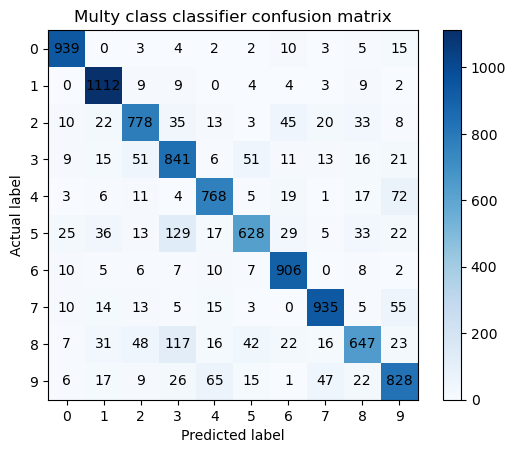

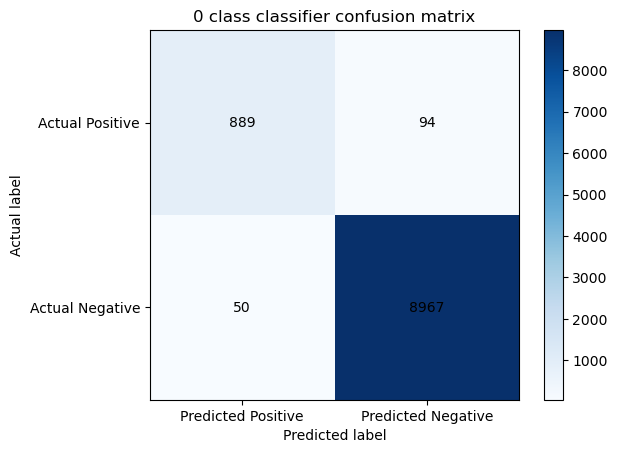

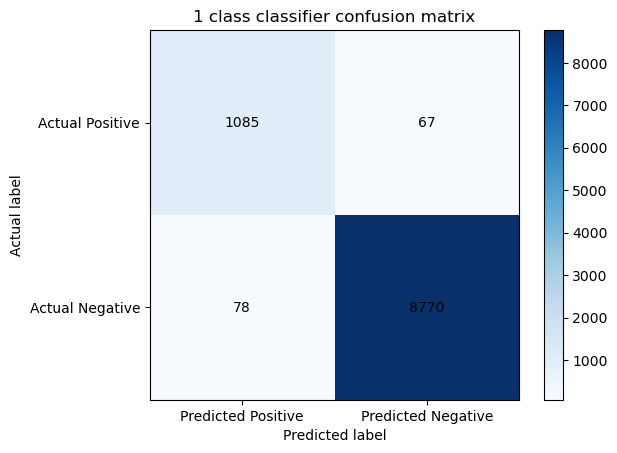

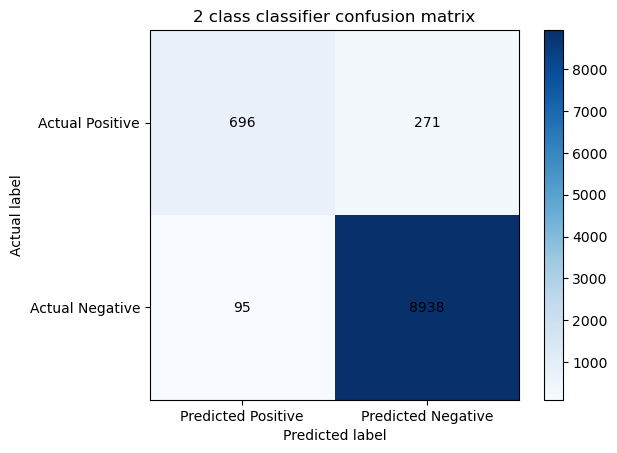

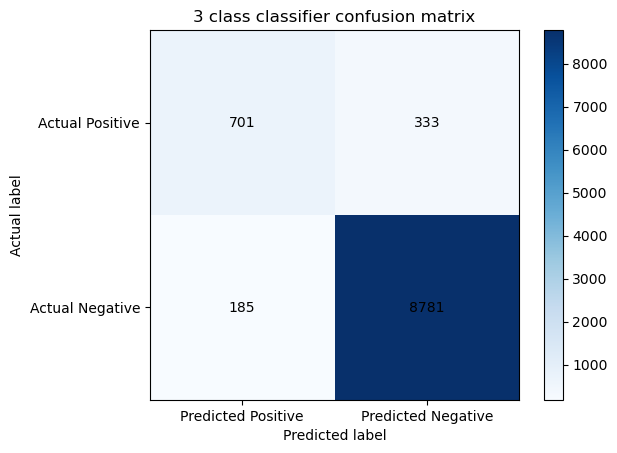

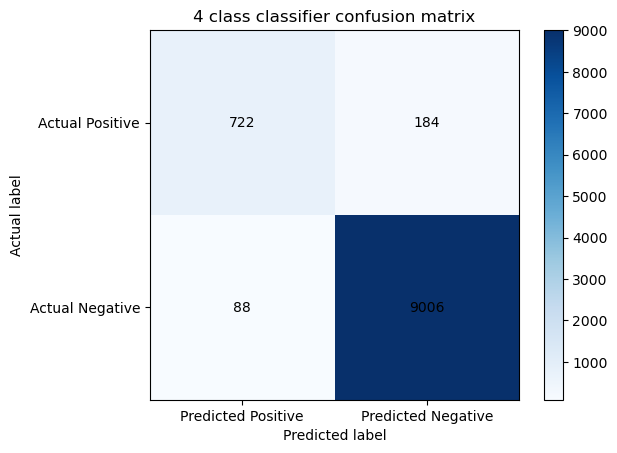

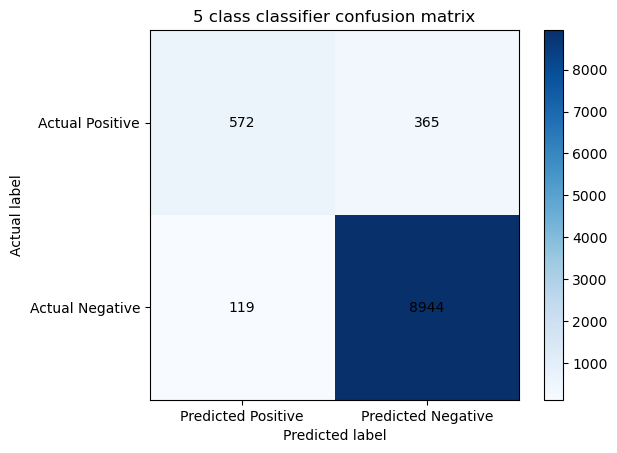

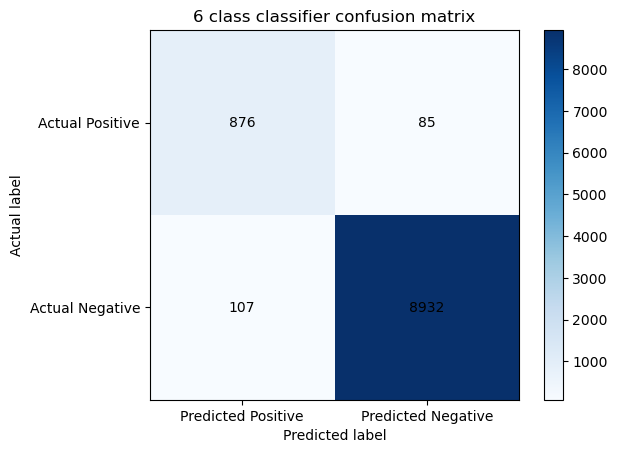

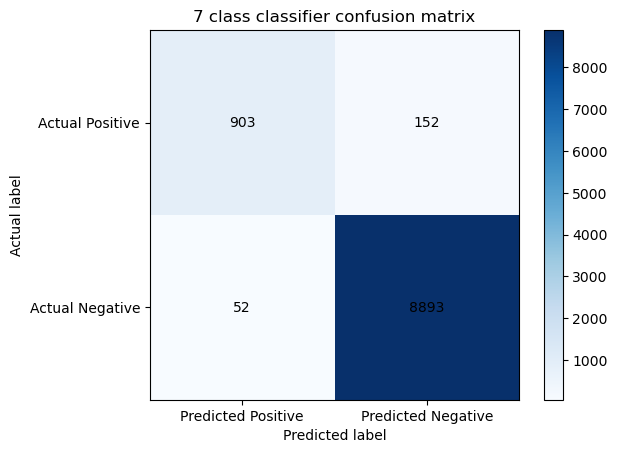

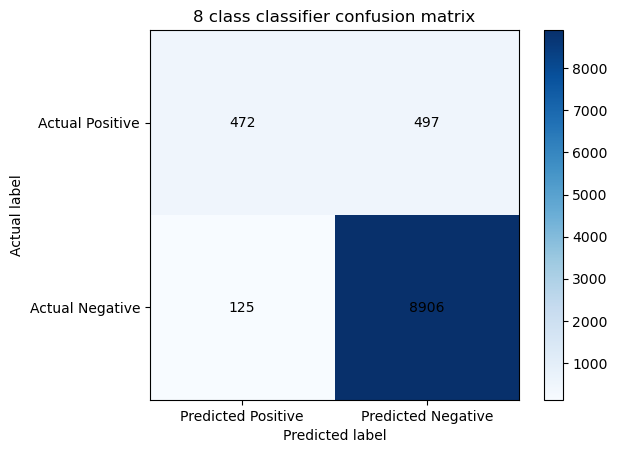

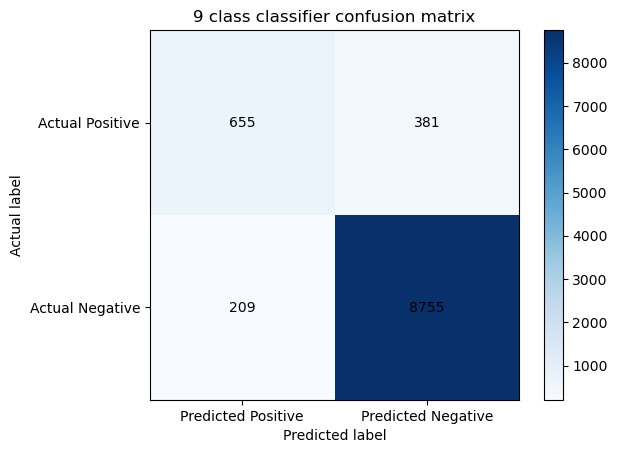

In [11]:
# plot confusion matricies

category_names =  [i for i in range(10)]
plot_confusion_matrix(multy_class_confusion_matrix, category_names,
                      category_names,"Multy class classifier confusion matrix")

x_category_names = [ "Predicted Positive", "Predicted Negative"]
y_category_names = [ "Actual Positive", "Actual Negative"]

for i in range(len(confusion_matrices)):
    plot_confusion_matrix(confusion_matrices[i],
                          x_category_names, y_category_names,
                         f"{i} class classifier confusion matrix")


In [12]:
# determine the accuracy of the multy class classifier
correcetly_classified = 0 
for i in range(10):
    correcetly_classified += multy_class_confusion_matrix[i][i]

multy_class_accuracy = correcetly_classified / data_test.shape[0]
print(f"multy class classifier Accuracy =  {multy_class_accuracy}")

for i in range(CATEGORIES):
    curr_confusion_matrix = confusion_matrices[i] 
    true_positive = curr_confusion_matrix[0,0]
    false_positive = curr_confusion_matrix[1,0]
    true_negative = curr_confusion_matrix[1,1]
    false_negative = curr_confusion_matrix[0,1]
    sensitivity = true_positive / (true_positive + false_negative)
    selectivity = true_negative / (true_negative + false_positive)
    print(f"{i} classifier Sensitivity = {sensitivity} | Selectivity = {selectivity}")
    
    

multy class classifier Accuracy =  0.8382
0 classifier Sensitivity = 0.9043743641912513 | Selectivity = 0.9944549184873017
1 classifier Sensitivity = 0.9418402777777778 | Selectivity = 0.9911844484629295
2 classifier Sensitivity = 0.7197518097207859 | Selectivity = 0.9894830067530167
3 classifier Sensitivity = 0.6779497098646035 | Selectivity = 0.9793664956502343
4 classifier Sensitivity = 0.7969094922737306 | Selectivity = 0.9903232900813723
5 classifier Sensitivity = 0.6104589114194237 | Selectivity = 0.9868696899481408
6 classifier Sensitivity = 0.9115504682622269 | Selectivity = 0.9881624073459453
7 classifier Sensitivity = 0.8559241706161137 | Selectivity = 0.9941866964784796
8 classifier Sensitivity = 0.4871001031991744 | Selectivity = 0.9861587864023917
9 classifier Sensitivity = 0.6322393822393823 | Selectivity = 0.9766845158411424


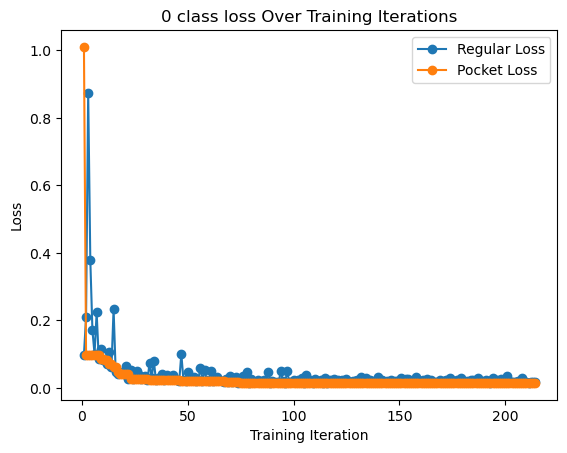

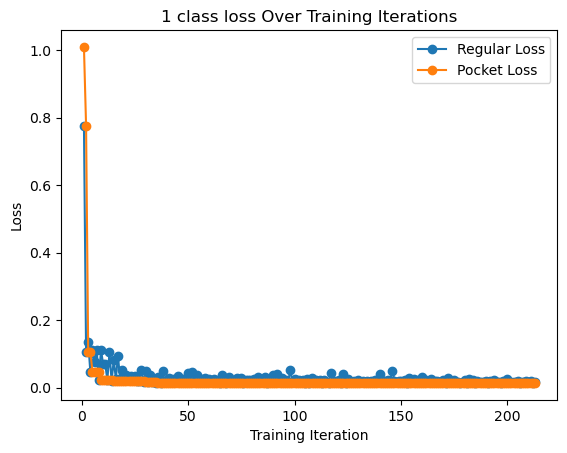

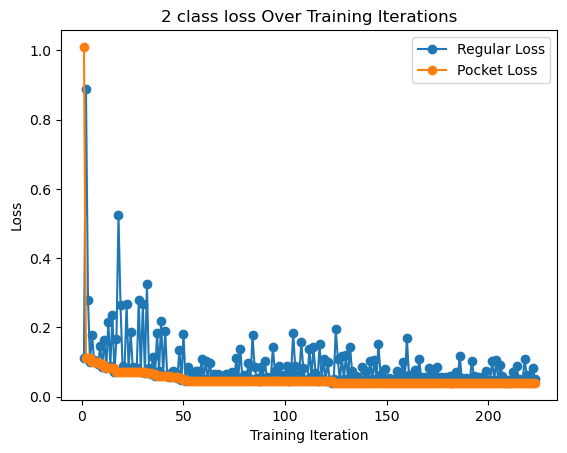

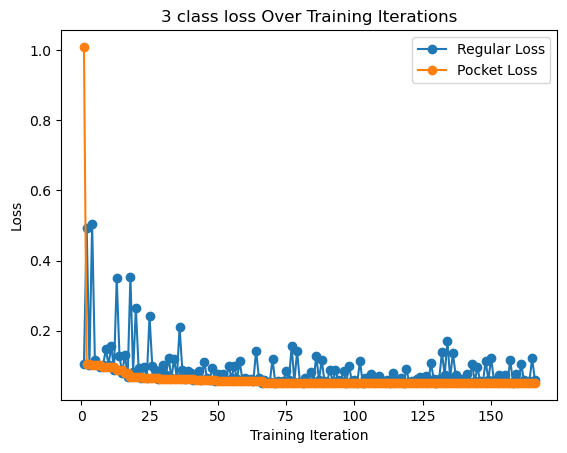

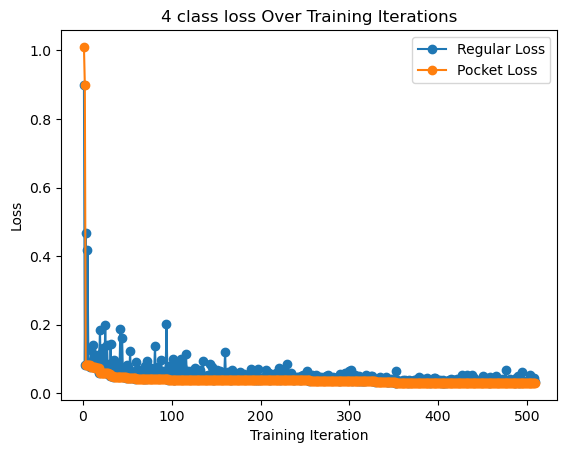

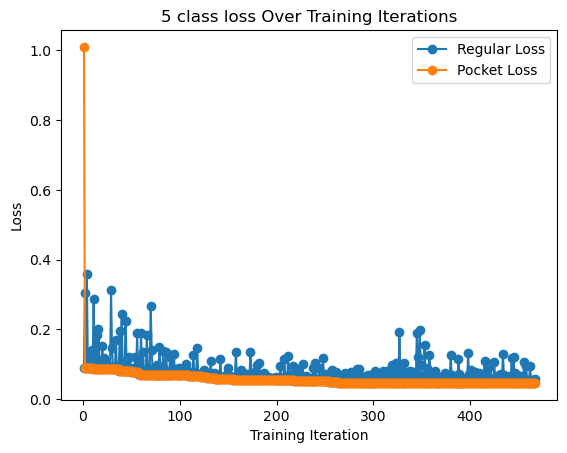

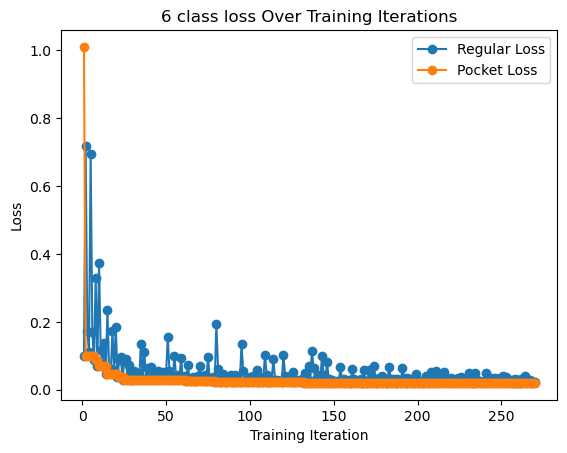

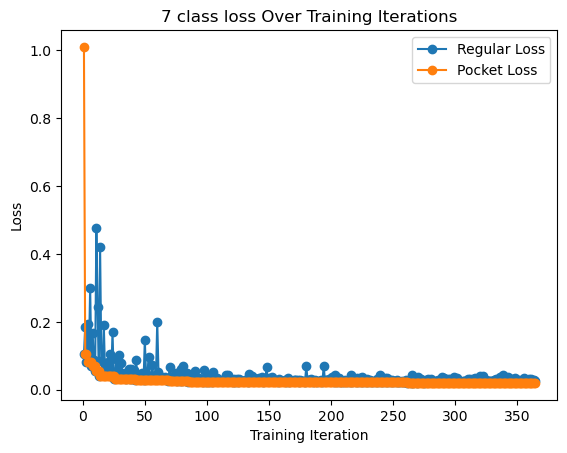

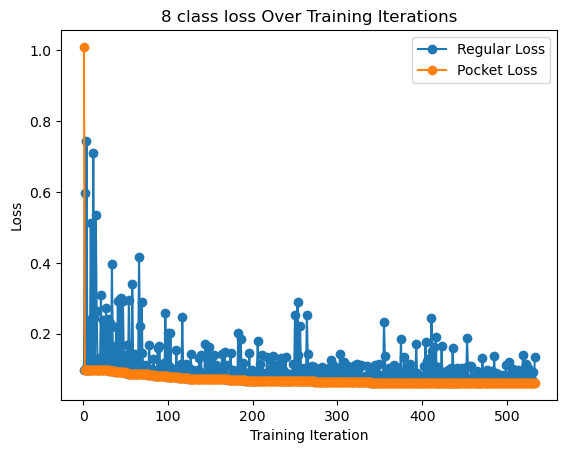

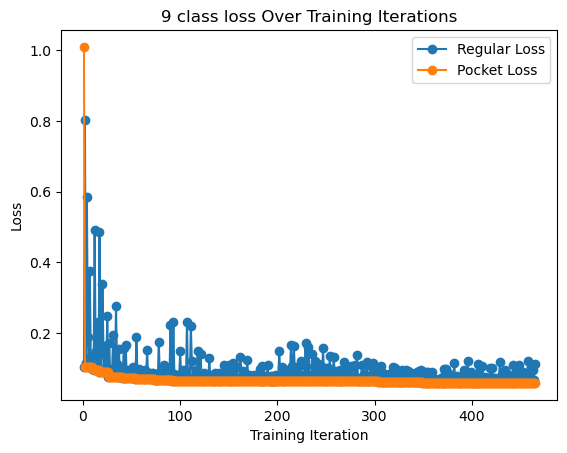

In [45]:
# plot loss throughout time 
for i in range(CATEGORIES):
    plot_loss_history(f"{i} class loss Over Training Iterations",
                      (binary_classifires[i].loss_history, "Regular Loss"),
                      (binary_classifires[i].pocket_loss_history, "Pocket Loss"))

### A4 “Provide a comprehensive discussion of your results, considering the model's overall performance and its effectiveness in distinguishing individual digits”
***
</br> </br> 

**Note:** The results presented in this analysis are based on a specific run of the program, and the outcomes may vary in different executions. 
</br> </br> 

Multi class model over all performance :</br>
multi class classifier Accuracy = 0.8438 which means that the model correctly classifies
more then 84 % of the testing data
</br> </br> 

Looking at its confusion matrix :

![Multi class  model confusion matrix](./preceptron_confusion.png)
</br> </br> 

We can see that it classifies all digits mostly correctly
although we can note that The digits 5 and 8 have been misclassified more than
The other classes
Where 5 is mostly misclassified as 3 and 8 mostly misclassified as either 2 or 3
</br> </br> 

While looking at the specific confusion matrices of each digit classifier most digits miss
classify a similar number of false positive as they do false negatives
</br> </br> 

![preceptron digit 4 confusion matrix](./preceptron_digit_4_confusion.png)
</br> </br> 

However the binary classifiers for 5 and 8, the digits that misclassify more of the data ( as
shown above ) have a lot more false negative then false positive meaning that the model is
more prone to missing instances of these digits rather than incorrectly assigning the digits 5
and 8 to other classes
</br> </br> 

![preceptron digit 5 confusion matrix](./preceptron_digit_5_confusion.png)
</br> </br> 

![preceptron digit 8 confusion matrix](./preceptron_digit_8_confusion.png)
</br> </br> 

This can also be seen in the low sensitivity and high selectivity of digits 5 and 8 as compared to all other digits
</br> </br> 

0 classifier Sensitivity = 0.9175991861648016 | Selectivity = 0.9942331152267938
1 classifier Sensitivity = 0.9401041666666666 | Selectivity = 0.9923146473779385
2 classifier Sensitivity = 0.7394002068252327 | Selectivity = 0.987601018487767
3 classifier Sensitivity = 0.6769825918762089 | Selectivity = 0.9846085210796341
4 classifier Sensitivity = 0.82560706401766 | Selectivity = 0.9830657576424016
__5 classifier Sensitivity = 0.5965848452508005 | Selectivity = 0.9890764647467726__
6 classifier Sensitivity = 0.8647242455775234 | Selectivity = 0.9931408341630711
7 classifier Sensitivity = 0.8691943127962085 | Selectivity = 0.9908328675237563
__8 classifier Sensitivity = 0.541795665634675 | Selectivity = 0.980954490089691__
9 classifier Sensitivity = 0.612934362934363 | Selectivity = 0.9719991075412762
</br> </br> 

As we can see all digits have high selectivity meaning that they can mostly distinguish digits
that are not the digits they are looking for
But as most other digits Sensitivity is high meaning they can recognize the digit they are
looking for
</br> </br> 

the binary classifiers for 5 and 8 have a relatively low sensitivity as shown above in bold
The binary classifier models implemented in the code have a hard stop to the training after
The 1000 iterations however, the training also stops after 100 iterations where there was no
improvement to the pocket weights meaning that in 100 consecutive iterations there was no
improvement to the models weights that is better than the current best improvement which
suggest that the model has plateaued . so that in practice the binary classifiers did not do
more than 600 iterations over the data while most binary classifiers did around 200 iterations
in total.
</br> </br> 

This can be seen in the following graphs
</br> </br> 

![preceptron digit 8 loss](./preceptron_digit_8_loss.png)
</br> </br> 

![preceptron digit 3 loss](./preceptron_digit_3_loss.png)
</br> </br> 

# Logistic regression 
***

In [ ]:

def softmax(vector, isBatch = True):
    # axis changes if we are doing softmax to 1 example or many examples
    axis = 1 if isBatch else 0
    exp_vector = np.exp(vector)  
    return exp_vector / np.sum(exp_vector, axis=axis, keepdims=True)
    
class LogisticRegressionClassifier:
    
    def __init__(self, num_classes, num_features, learning_rate=0.01, num_iterations=1000 ):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.num_classes = num_classes
        self.weights = np.zeros((num_features, self.num_classes))
        self.losses = []


    def calculate_loss(self, y, probabilities, num_examples):
        
        indices = np.arange(num_examples)
        # use the indices to select the predicted probabilities for the true class labels
        selected_probabilities = probabilities[indices, y]
        log_likelihood = -np.log(selected_probabilities)
        loss = np.mean(log_likelihood) 
        return loss

    def train(self, X, y):
        
        num_examples = X.shape[0]
        one_hot_labels = np.eye(self.num_classes)[y]
        
        for _ in range(self.num_iterations):
            
            probabilities = self.calc_probabilities(X,True)
            
            gradient = np.dot(X.T, probabilities - one_hot_labels) / num_examples

            self.weights -= self.learning_rate * gradient

            # Calculate and store the loss at each iteration
            loss = self.calculate_loss(y, probabilities , num_examples)
            self.losses.append(loss)
            
    def predict(self, X, isBatch):
        probabilities = self.calc_probabilities(X, isBatch)
        axis = 1 if isBatch else 0  
        return np.argmax(probabilities, axis=axis)
    
    def calc_probabilities(self, X, isBatch):
        scores = np.dot(X, self.weights)
        return  softmax(scores, isBatch)
        
    
features = data_train.shape[1]
logistic_classifier = LogisticRegressionClassifier(CATEGORIES, features,0.01, 1000)
logistic_classifier.train(data_train, labels_train)
print("done")

## Logistic regression results analysis
***
__B2. Calculate confusion matrix and accuracy (ACC)
for the multi-class classification problem on the test data.__


In [ ]:
# create and plot confusion matrix 
logistic_pred_test = logistic_classifier.predict(data_test, True)
logistic_confusion_matrix = create_confusion_matrix(labels_test, logistic_pred_test, CATEGORIES)

category_names =  [i for i in range(CATEGORIES)]
plot_confusion_matrix(logistic_confusion_matrix, category_names,
                      category_names,"Logistic regression classifier confusion matrix")


In [ ]:
# determine the accuracy 
logistic_pred_correct = np.sum(logistic_pred_test == labels_test)
test_size = labels_test.shape[0]
print(f" accurecy = {(logistic_pred_correct /test_size) * 100 }%")

### B3. Calculate the table of confusion for each digit and compute sensitivity (TPR) for each class.

In [ ]:

num_test_examples = data_test.shape[0]

# Calculate the table of confusion for each digit 
true_positives = np.diag(logistic_confusion_matrix)
false_negatives = np.sum(logistic_confusion_matrix, axis = 1 ) - true_positives  
false_positives = np.sum(logistic_confusion_matrix, axis = 0 ) - true_positives  
true_negatives = num_test_examples - (true_positives + false_negatives + false_positives) 

# create a confussion matricies for each digit sepratly  
digit_confussion_matricies = []
for i in range(CATEGORIES):
    digit_confussion_matrix = np.vstack((true_positives[i], false_negatives[i],
               false_positives[i], true_negatives[i])).reshape(2, 2) 
    digit_confussion_matricies.append(digit_confussion_matrix)
    
# convert the list to a NumPy array 
digit_confussion_matricies = np.array(digit_confussion_matricies)

x_category_names = [ "Predicted Positive", "Predicted Negative"]
y_category_names = [ "Actual Positive", "Actual Negative"]

for i in range(len(digit_confussion_matricies)):
    plot_confusion_matrix(digit_confussion_matricies[i],
                          x_category_names, y_category_names,
                         f"{i} class confusion matrix")





In [ ]:
# compute sensitivity and selectivity
sensitivity = true_positives / (true_positives + false_negatives)
selectivity = true_negatives / (true_negatives + false_positives)
for i in range(CATEGORIES):
        print(f"{i} Sensitivity = {sensitivity[i]} | Selectivity = {selectivity[i]}")

In [ ]:
# plot loss history 
    
plot_loss_history(logistic_classifier.losses,"Logistic regression loss Over training iterations" )

### B4. Discuss the Results
***
</br>
**Note:** The results presented in this analysis are based on a specific run of the program, and the outcomes may vary in different executions.

Logistic regression model overall performance: </br> </br>
Accuracy = 85.86% </br>
which means that the model correctly classifies more than 85% of the testing data.

Looking at its confusion matrix:

![Logistic regression model confusion matrix](./logistic_confusion_matrix.png)
</br></br>
We can see that it classifies all digits mostly correctly.

While looking at the specific confusion matrices of each digit, most digits misclassify a similar number of false positives as they do false negatives, with the exception of digit 5, which seems to classify more false negatives. This indicates that the model is more prone to missing instances of 5 rather than incorrectly assigning the digit 5 to other digits.

![Digit 5 confusion matrix](./logistic_digit_5_confusion.png)
</br></br>

This can also be seen in the relatively low sensitivity and high selectivity of digit 5 compared to all other digits.
</br></br>

- Sensitivity and Selectivity values for each digit:

0 Sensitivity = 0.9440488301119023 | Selectivity = 0.990684263058667 </br>
1 Sensitivity = 0.9557291666666666 | Selectivity = 0.9799954792043399 </br>
2 Sensitivity = 0.8179937952430196 | Selectivity = 0.9859404406066644 </br>
3 Sensitivity = 0.8413926499032882 | Selectivity = 0.9778050412670087 </br>
4 Sensitivity = 0.8532008830022075 | Selectivity = 0.984605234220365 </br>
__5 Sensitivity = 0.7225186766275347 | Selectivity = 0.989517819706499__ </br>
6 Sensitivity = 0.9094693028095734 | Selectivity = 0.986171036619095 </br>
7 Sensitivity = 0.8862559241706162 | Selectivity = 0.9887087758524316 </br>
8 Sensitivity = 0.7894736842105263 | Selectivity = 0.9797364632931015 </br>
9 Sensitivity = 0.8416988416988417 | Selectivity = 0.9795850066934404 </br>

__Hyperparameter Tuning and Model Performance:__

During the testing and trial and error process of hyperparameter tuning, I couldn't get the model to achieve a loss smaller than 0.606, and the accuracy remained at approximately 85%. despite various attempts to optimize hyperparameters, including changing the learning rate and initializing weights randomly.


# Linear regression model 
***
### C1. Formulate the digit classification problem as a linear regression task.


In [ ]:

class LinearRegressionClassifier:
    
    def __init__(self, num_classes, num_features, learning_rate=0.01, num_iterations=1000 ):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.num_classes = num_classes
        self.weights = np.zeros((num_features, self.num_classes))
        self.losses = []
    
    def train(self, X, y):
        
        num_examples = y.shape[0]
        one_hot_labels = np.eye(self.num_classes)[y]
        
        for _ in range(self.num_iterations):
            
            pred = np.dot(X,self.weights)
            
            # find error
            error = one_hot_labels - pred
            mean_squared_error = np.mean(np.square(error))
            self.losses.append(mean_squared_error)
            
            gradient = -2 * np.dot(X.T, error) / num_examples
            
            self.weights -= self.learning_rate * gradient
            
    def predict(self,X):
        # Convert predictions to class labels (index of maximum value in each row)
        return np.argmax(np.dot(X, self.weights), axis=1)

features = data_train.shape[1]
linear_classifier = LinearRegressionClassifier(CATEGORIES, features,0.01, 1000)
linear_classifier.train(data_train, labels_train)
print("done")        

## Linear regression results analysis
***
### C2. Evaluate the performance of the linear regression models on the test set.

In [ ]:
plot_loss_history(linear_classifier.losses,"Linear regression loss Over training iterations" )

In [ ]:
# create and plot confusion matrix 
linear_pred_test = linear_classifier.predict(data_test)
linear_confusion_matrix = create_confusion_matrix(labels_test, linear_pred_test, CATEGORIES)

category_names =  [i for i in range(CATEGORIES)]
plot_confusion_matrix(linear_confusion_matrix, category_names,
                      category_names,"Linear regression classifier confusion matrix")


In [ ]:
# determine the accuracy 
linear_pred_correct = np.sum(linear_pred_test == labels_test)
test_size = labels_test.shape[0]
print(f" accurecy = {(linear_pred_correct /test_size) * 100 }%")

In [ ]:
# Calculate the table of confusion for each digit
num_test_examples = data_test.shape[0]

true_positives = np.diag(linear_confusion_matrix)
false_negatives = np.sum(linear_confusion_matrix, axis = 1 ) - true_positives  
false_positives = np.sum(linear_confusion_matrix, axis = 0 ) - true_positives  
true_negatives = num_test_examples - (true_positives + false_negatives + false_positives) 

# create a confussion matricix for each digit sepratly  
linear_digit_confussion_matricies = []
for i in range(CATEGORIES):
    digit_confussion_matrix = np.vstack((true_positives[i], false_negatives[i],
               false_positives[i], true_negatives[i])).reshape(2, 2) 
    linear_digit_confussion_matricies.append(digit_confussion_matrix)
    
# convert the list to a NumPy array 
linear_digit_confussion_matricies = np.array(linear_digit_confussion_matricies)

x_category_names = [ "Predicted Positive", "Predicted Negative"]
y_category_names = [ "Actual Positive", "Actual Negative"]

for i in range(len(linear_digit_confussion_matricies)):
    plot_confusion_matrix(linear_digit_confussion_matricies[i],
                          x_category_names, y_category_names,
                         f"{i} class confusion matrix")



In [ ]:
# compute sensitivity and selectivity
sensitivity = true_positives / (true_positives + false_negatives)
selectivity = true_negatives / (true_negatives + false_positives)
for i in range(CATEGORIES):
        print(f"{i} Sensitivity = {sensitivity[i]} | Selectivity = {selectivity[i]}")

### C3.Compare the results 

The results obtained using linear regression, perceptron algorithm, and softmax regression are all quite similar. 
</br></br>
__Accurecy__</br>
linear regression: 85.45% </br>
softmax regression: 85.86% </br>
perceptron algorithm: 84.38% </br> 
</br></br>
__confusion matricies__

![all confusion matricies ](./all_confusion.png)
</br></br>
We can see that all classifiers classify all digits mostly correctly.

While looking at the specific confusion matrices of each digit for each classifier all classifiers misclassify a similar number of false positives as they do false negatives for each digit. the exception is digit 5, for which all the examined classifiers show a large number of false negatives. this might suggest a common problem with all the examined models or that the data for digit 5 is too similar to other digits such as 3 and 8 

![digit 5 all confusion matricies](./digit_5_all_confusion.png)
</br></br>

This can also be seen in the relatively low sensitivity and high selectivity of digit 5 compared to all other digits.
</br></br>

 __Sensitivity and Selectivity values for each digit:__ </br></br>
- linear regression:</br>
0 Sensitivity = 0.9440488301119023 | Selectivity = 0.9899079516468892 </br>
1 Sensitivity = 0.9696180555555556 | Selectivity = 0.969371609403255 </br>
2 Sensitivity = 0.8086866597724922 | Selectivity = 0.9892615963688697 </br>
3 Sensitivity = 0.8433268858800773 | Selectivity = 0.9774704438991747 </br>
4 Sensitivity = 0.8774834437086093 | Selectivity = 0.9820760941279965 </br>
__5 Sensitivity = 0.6894343649946638 | Selectivity = 0.9904005296259517__ </br>
6 Sensitivity = 0.9281997918834547 | Selectivity = 0.9867241951543312 </br>
7 Sensitivity = 0.8834123222748815 | Selectivity = 0.9859139183901621 </br>
8 Sensitivity = 0.737874097007224 | Selectivity = 0.9841656516443362 </br>
9 Sensitivity = 0.8359073359073359 | Selectivity = 0.9827086122266845 </br>
</br> </br>
- logistic regression :</br>
0 Sensitivity = 0.9440488301119023 | Selectivity = 0.990684263058667 </br>
1 Sensitivity = 0.9557291666666666 | Selectivity = 0.9799954792043399 </br>
2 Sensitivity = 0.8179937952430196 | Selectivity = 0.9859404406066644 </br>
3 Sensitivity = 0.8413926499032882 | Selectivity = 0.9778050412670087 </br>
4 Sensitivity = 0.8532008830022075 | Selectivity = 0.984605234220365 </br>
__5 Sensitivity = 0.7225186766275347 | Selectivity = 0.989517819706499__ </br>
6 Sensitivity = 0.9094693028095734 | Selectivity = 0.986171036619095 </br>
7 Sensitivity = 0.8862559241706162 | Selectivity = 0.9887087758524316 </br>
8 Sensitivity = 0.7894736842105263 | Selectivity = 0.9797364632931015 </br>
9 Sensitivity = 0.8416988416988417 | Selectivity = 0.9795850066934404 </br>
</br></br>
- perceptron algorithm : </br> 
0 classifier Sensitivity = 0.9175991861648016 | Selectivity = 0.9942331152267938 </br>
1 classifier Sensitivity = 0.9401041666666666 | Selectivity = 0.9923146473779385 </br>
2 classifier Sensitivity = 0.7394002068252327 | Selectivity = 0.987601018487767 </br>
3 classifier Sensitivity = 0.6769825918762089 | Selectivity = 0.9846085210796341 </br>
4 classifier Sensitivity = 0.82560706401766 | Selectivity = 0.9830657576424016 </br>
__5 classifier Sensitivity = 0.5965848452508005 | Selectivity = 0.9890764647467726__ </br>
6 classifier Sensitivity = 0.8647242455775234 | Selectivity = 0.9931408341630711 </br>
7 classifier Sensitivity = 0.8691943127962085 | Selectivity = 0.9908328675237563 </br>
__8 classifier Sensitivity = 0.541795665634675 | Selectivity = 0.980954490089691__ </br>
9 classifier Sensitivity = 0.612934362934363 | Selectivity = 0.9719991075412762 </br>
</br></br>
further more we will note that of all the exmained models the proceptron had the lowest sensitivity for all most all the classes for some reason 


### C4. Discuss the strengths, weaknesses, and limitations of using linear regression for MNIST digit classification.



__strengths of using linear regression for MNIST digit classification:__
</br>
- Efficiency: training linear regression is computationally efficient as it involves solving a linear system and requiers only a few matrix operations which computers are quite good at  

</br>

__weaknesses and limitations of using linear regression for MNIST digit classification:__

- Assumption of linearity: linear regression assumes a linear relationship between input   features and the target variable which is a prolblem if the relationship between the input  features and the target variable is more complex ( polinomial for example )
in addition MNIST digits data set is a dataset of images
that have a spatial realationship where the pixal is in the image and what pixals are next to  it is an important and might be ignored by linear regression 

